In [2]:
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 2.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_text
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [4]:
transactions_train = pd.read_excel('transactionsdata_Train.xlsx')
email_train = pd.read_excel('Emaildata_Train.xlsx')
customer_test = pd.read_excel('Customerdata_Test.xlsx')
train_data = pd.read_excel('Train.xlsx')
test_data = pd.read_excel('Test.xlsx')

In [5]:

data = train_data.merge(transactions_train, on='CustomerID', how='left').merge(email_train, on='CustomerID', how='left')

print(data.describe())
print(data.isnull().sum())

       OrderQuantity
count   3.883469e+06
mean    8.632433e+01
std     4.650906e+01
min     0.000000e+00
25%     5.500000e+01
50%     7.700000e+01
75%     1.060000e+02
max     1.501000e+03
CustomerID            0
RetentionPotential    0
DateOfOrder           0
timestamp_x           0
OrderQuantity         0
DateOfemail           0
EmailType             0
timestamp_y           0
MailOpened            0
MailClicked           0
dtype: int64


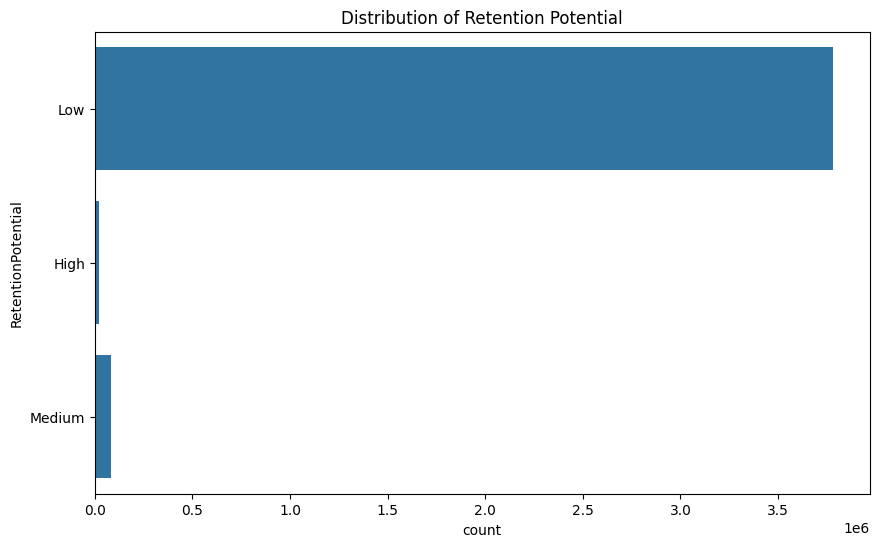

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(data['RetentionPotential'])
plt.title('Distribution of Retention Potential')
plt.show()

In [7]:


data['DateOfOrder'] = pd.to_datetime(data['DateOfOrder'])
data['OrderMonth'] = data['DateOfOrder'].dt.month
data['OrderYear'] = data['DateOfOrder'].dt.year


In [8]:
X = data.drop(['CustomerID', 'RetentionPotential'], axis=1)
y = data['RetentionPotential']

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = ['EmailType', 'MailOpened', 'MailClicked']
le = LabelEncoder()

for column in categorical_columns:
    X_train[column] = le.fit_transform(X_train[column])
    X_valid[column] = le.transform(X_valid[column])


In [11]:
X_train = pd.get_dummies(X_train, columns=categorical_columns)
X_valid = pd.get_dummies(X_valid, columns=categorical_columns)


In [12]:
X_train['timestamp_x'] = pd.to_datetime(X_train['timestamp_x'])
X_train['timestamp_y'] = pd.to_datetime(X_train['timestamp_y'])

X_train['timestamp_x_hour'] = X_train['timestamp_x'].dt.hour
X_train['timestamp_y_hour'] = X_train['timestamp_y'].dt.hour

X_train = X_train.drop(['timestamp_x', 'timestamp_y'], axis=1)


In [13]:
print("Data types in X_train after processing:")
print(X_train.dtypes)


Data types in X_train after processing:
DateOfOrder         datetime64[ns]
OrderQuantity                int64
DateOfemail                 object
OrderMonth                   int32
OrderYear                    int32
EmailType_0                   bool
EmailType_1                   bool
MailOpened_0                  bool
MailOpened_1                  bool
MailClicked_0                 bool
MailClicked_1                 bool
MailClicked_2                 bool
timestamp_x_hour             int32
timestamp_y_hour             int32
dtype: object


In [14]:
bool_columns = ['EmailType_0', 'EmailType_1', 'MailOpened_0', 'MailOpened_1', 'MailClicked_0', 'MailClicked_1', 'MailClicked_2']
for column in bool_columns:
    X_train[column] = X_train[column].astype(int)

In [15]:
X_train['DateOfemail'] = pd.factorize(X_train['DateOfemail'])[0]

print("Data types in X_train after processing:")
print(X_train.dtypes)


Data types in X_train after processing:
DateOfOrder         datetime64[ns]
OrderQuantity                int64
DateOfemail                  int64
OrderMonth                   int32
OrderYear                    int32
EmailType_0                  int64
EmailType_1                  int64
MailOpened_0                 int64
MailOpened_1                 int64
MailClicked_0                int64
MailClicked_1                int64
MailClicked_2                int64
timestamp_x_hour             int32
timestamp_y_hour             int32
dtype: object


In [16]:
X_valid = X_valid.reindex(columns=X_train.columns, fill_value=0)


In [17]:
bool_columns = ['EmailType_0', 'EmailType_1', 'MailOpened_0', 'MailOpened_1', 'MailClicked_0', 'MailClicked_1', 'MailClicked_2']
for column in bool_columns:
    if column in X_valid.columns:
        X_valid[column] = X_valid[column].astype(int)

if 'DateOfOrder' in X_valid.columns:
    X_valid['DateOfOrder'] = pd.to_datetime(X_valid['DateOfOrder'])
    X_valid['DateOfOrder_day'] = (X_valid['DateOfOrder'] - X_valid['DateOfOrder'].min()).dt.days
    X_valid = X_valid.drop('DateOfOrder', axis=1)

X_valid = X_valid.reindex(columns=X_train.columns, fill_value=0)


In [35]:

datetime_columns = X_train.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns.tolist()

string_columns = X_train.select_dtypes(include=['object']).columns.tolist()

for column in string_columns:
    try:
        X_train[column] = X_train[column].astype(float)
    except ValueError:
        print(f"Column {column} could not be converted to float and will be excluded.")
        X_train = X_train.drop(column, axis=1)

for column in datetime_columns:
    X_train[column + '_day'] = (X_train[column] - X_train[column].min()).dt.days
    X_train[column + '_hour'] = X_train[column].dt.hour
    X_train[column + '_month'] = X_train[column].dt.month
    X_train[column + '_year'] = X_train[column].dt.year

    X_train = X_train.drop(column, axis=1)



In [22]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)

y_valid_encoded = label_encoder.transform(y_valid)

print("Unique classes in y_train_encoded:", np.unique(y_train_encoded))
print("Unique classes in y_valid_encoded:", np.unique(y_valid_encoded))


Unique classes in y_train_encoded: [0 1 2]
Unique classes in y_valid_encoded: [0 1 2]


In [36]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

xgb_model.fit(X_train_scaled, y_train_encoded)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [37]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(xgb_model, X_train_scaled, y_train, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

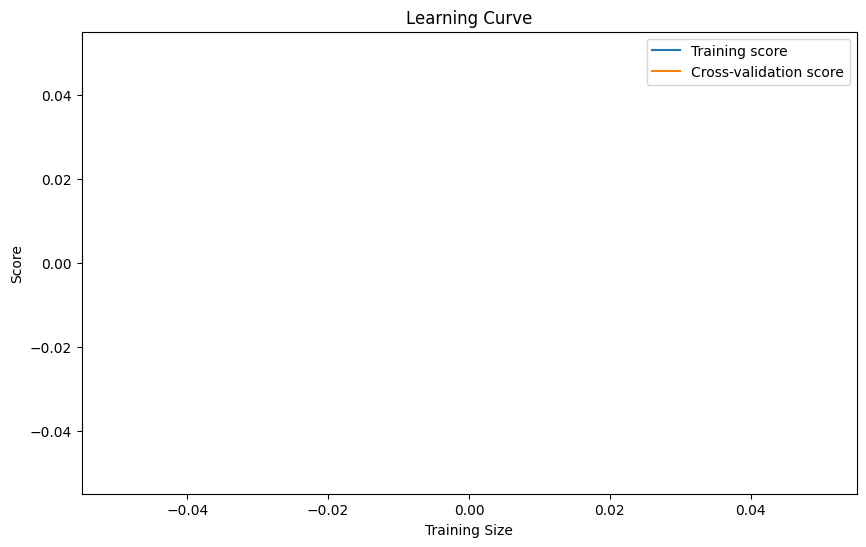

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.show()

In [42]:

import pandas as pd


X_test = pd.read_excel('Test.xlsx')


datetime_columns_test = X_test.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns.tolist()

string_columns_test = X_test.select_dtypes(include=['object']).columns.tolist()

for column in string_columns_test:
    try:
        X_test[column] = X_test[column].astype(float)
    except ValueError:
        print(f"Column {column} could not be converted to float and will be excluded.")
        X_test = X_test.drop(column, axis=1)

for column in datetime_columns_test:
    X_test[column + '_day'] = (X_test[column] - X_test[column].min()).dt.days
    X_test[column + '_hour'] = X_test[column].dt.hour
    X_test[column + '_month'] = X_test[column].dt.month
    X_test[column + '_year'] = X_test[column].dt.year


    X_test = X_test.drop(column, axis=1)


X_test = X_test.reindex(columns=X_train.columns, fill_value=0)



Column CustomerID could not be converted to float and will be excluded.


In [46]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd


n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_train_scaled)


print("KMeans centroids:\n", kmeans.cluster_centers_)


print("Scaler mean:", scaler.mean_)
print("Scaler var:", scaler.var_)


if X_test.shape[1] == X_train_scaled.shape[1]:
    X_test_scaled = scaler.transform(X_test)
    test_data = pd.DataFrame(X_test)
    test_data['Segment'] = kmeans.predict(X_test_scaled)
else:
    print("Mismatch in number of features between training and test data.")



KMeans centroids:
 [[ 1.98496354e-02 -1.93844048e-01  4.44609960e-04 -4.18540069e-01
   1.66612708e-01 -1.66612708e-01  4.91627371e-02 -4.91627371e-02
  -1.66612708e-01  8.48108850e-02  4.36702515e-03 -1.23368592e-03
   2.16982875e-03 -4.17842031e-01  0.00000000e+00  4.44609960e-04
  -4.18540069e-01]
 [-6.86642406e-02  7.72146638e-01 -5.78879655e-03  1.78837474e+00
   1.66612708e-01 -1.66612708e-01 -1.20466565e-02  1.20466565e-02
  -1.66612708e-01  6.81240116e-02  2.34876261e-02  5.07140270e-03
  -8.92066686e-03  1.78479233e+00  0.00000000e+00 -5.78879655e-03
   1.78837474e+00]
 [-1.09823487e-01  3.77806721e-01  2.66054827e-02 -1.28928384e-02
  -6.00194314e+00  6.00194314e+00 -1.35247708e+00  1.35247708e+00
   6.00194314e+00 -2.94107089e+00 -2.88054600e-01  1.32951750e-03
  -2.33158553e-03 -8.77029333e-03  0.00000000e+00  2.66054827e-02
  -1.28928384e-02]]
Scaler mean: [8.63305898e+01 9.70458441e+02 7.16492633e+00 2.01310992e+03
 9.72989998e-01 2.70100023e-02 6.46542476e-01 3.53457524e

In [47]:

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train_scaled)

KMeans(n_clusters=3, random_state=42)

In [49]:

test_data['Segment'] = kmeans.predict(X_test_scaled)

In [50]:
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [51]:
print("Number of features in X_train:", X_train.shape[1])
print("Number of feature names provided:", len(X.columns))


Number of features in X_train: 17
Number of feature names provided: 10


In [52]:
print("Columns in X_train:")
print(X_train.columns)

Columns in X_train:
Index(['OrderQuantity', 'DateOfemail', 'OrderMonth', 'OrderYear',
       'EmailType_0', 'EmailType_1', 'MailOpened_0', 'MailOpened_1',
       'MailClicked_0', 'MailClicked_1', 'MailClicked_2', 'timestamp_x_hour',
       'timestamp_y_hour', 'DateOfOrder_day', 'DateOfOrder_hour',
       'DateOfOrder_month', 'DateOfOrder_year'],
      dtype='object')


In [60]:

feature_names = list(X_train.columns)

print("Feature names list length:", len(feature_names))


Feature names list length: 17


In [59]:

tree_rules = export_text(tree_model, feature_names=list(X_train.columns))
print(tree_rules)

|--- EmailType_0 <= -2.92
|   |--- DateOfOrder_day <= -0.96
|   |   |--- OrderQuantity <= -0.56
|   |   |   |--- DateOfOrder_day <= -1.44
|   |   |   |   |--- timestamp_y_hour <= -0.88
|   |   |   |   |   |--- class: Medium
|   |   |   |   |--- timestamp_y_hour >  -0.88
|   |   |   |   |   |--- class: Low
|   |   |   |--- DateOfOrder_day >  -1.44
|   |   |   |   |--- DateOfemail <= 1.13
|   |   |   |   |   |--- class: Low
|   |   |   |   |--- DateOfemail >  1.13
|   |   |   |   |   |--- class: Low
|   |   |--- OrderQuantity >  -0.56
|   |   |   |--- DateOfemail <= -1.08
|   |   |   |   |--- DateOfemail <= -1.27
|   |   |   |   |   |--- class: Low
|   |   |   |   |--- DateOfemail >  -1.27
|   |   |   |   |   |--- class: Medium
|   |   |   |--- DateOfemail >  -1.08
|   |   |   |   |--- DateOfemail <= 2.23
|   |   |   |   |   |--- class: Low
|   |   |   |   |--- DateOfemail >  2.23
|   |   |   |   |   |--- class: Low
|   |--- DateOfOrder_day >  -0.96
|   |   |--- DateOfemail <= 0.85
|   |

In [58]:
feature_importances = pd.Series(tree_model.feature_importances_, index=X_train.columns)
top_features = feature_importances.nlargest(5)
print(top_features)

EmailType_0         0.401329
DateOfOrder_day     0.388277
OrderQuantity       0.107917
DateOfemail         0.092008
timestamp_x_hour    0.005715
dtype: float64


In [57]:

print("Tree Rules:")
print(tree_rules)

print("Feature Importances:")
print(feature_importances)
print("Top Features:")
print(top_features)


Tree Rules:
|--- EmailType_0 <= -2.92
|   |--- DateOfOrder_day <= -0.96
|   |   |--- OrderQuantity <= -0.56
|   |   |   |--- DateOfOrder_day <= -1.44
|   |   |   |   |--- timestamp_y_hour <= -0.88
|   |   |   |   |   |--- class: Medium
|   |   |   |   |--- timestamp_y_hour >  -0.88
|   |   |   |   |   |--- class: Low
|   |   |   |--- DateOfOrder_day >  -1.44
|   |   |   |   |--- DateOfemail <= 1.13
|   |   |   |   |   |--- class: Low
|   |   |   |   |--- DateOfemail >  1.13
|   |   |   |   |   |--- class: Low
|   |   |--- OrderQuantity >  -0.56
|   |   |   |--- DateOfemail <= -1.08
|   |   |   |   |--- DateOfemail <= -1.27
|   |   |   |   |   |--- class: Low
|   |   |   |   |--- DateOfemail >  -1.27
|   |   |   |   |   |--- class: Medium
|   |   |   |--- DateOfemail >  -1.08
|   |   |   |   |--- DateOfemail <= 2.23
|   |   |   |   |   |--- class: Low
|   |   |   |   |--- DateOfemail >  2.23
|   |   |   |   |   |--- class: Low
|   |--- DateOfOrder_day >  -0.96
|   |   |--- DateOfemail <